In [1]:
import argparse
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image

import os
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches

#==========================================================================
# JUPYTER PATH STUFF. Not present in the main script coz does not affect it
# =========================================================================

os.chdir("..")


root = Path().resolve()
while root != root.parent:
    if (root / "scripts").is_dir():
        sys.path.insert(0, str(root))
        print("Added to sys.path:", root)
        break
    root = root.parent
else:
    raise RuntimeError("Could not find 'scripts' directory above this notebook")

from scripts.src import (
    build_model_and_tokenizer,
    get_image_transform,
    get_label_text_embeddings,
)

Added to sys.path: /home/woody/iwi5/iwi5362h/ALBEF


In [2]:
from scripts.albef_gradcam import (
    register_vit_gradcam_hooks,
    remove_vit_gradcam_hooks,
    generate_albef_gradcam,
    upsample_cam,
)

In [3]:
def infer_png_path(images_root: Path, image_id: str) -> Path:
    png_path = images_root / f"{image_id}.png"
    if not png_path.exists():
        raise FileNotFoundError(f"PNG not found for image_id={image_id}: {png_path}")
    return png_path

In [4]:
images_root = Path("/home/woody/iwi5/iwi5362h/data/vindr_cxr/test")
output_dir = Path("/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad_hooks")
output_dir.mkdir(parents=True, exist_ok=True)

In [5]:
config_path = "configs/Pretrain.yaml"
ckpt_path = "output_mimic_a40_transformations/checkpoint_29.pth"
device = "cuda"

In [6]:
torch.cuda.get_device_name(0)

'NVIDIA A40'

In [7]:
# Load model/tokenizer/config once and reuse
model, tokenizer, config, device = build_model_and_tokenizer(
    config_path=config_path,
    ckpt_path=ckpt_path,
    device=device,
)

image_res = config["image_res"]

[Model] Building ALBEF...
[Model] State dict loaded: <All keys matched successfully>


In [8]:
transform = get_image_transform(image_res)
model.eval()

# ---- Register Grad-CAM hooks ----
handles = register_vit_gradcam_hooks(model)
print("[Grad-CAM] Hooks registered.")

[Grad-CAM] Using visual_encoder.blocks[9] for CAM
[Grad-CAM] Hooks registered.


In [9]:
# Load label CSV to get image_ids + label names
df = pd.read_csv("/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/image_labels_test.csv")
id_col = df.columns[0]
all_label_cols = list(df.columns[1:])
print(f"[Data] Found {len(df)} rows, {len(all_label_cols)} labels")

[Data] Found 3000 rows, 28 labels


In [10]:
# For debugging a small batch
df = df.iloc[: 100].reset_index(drop=True)
print(f"[Data] Limiting to {len(df)} images (max_images=100)")

[Data] Limiting to 100 images (max_images=100)


In [11]:
df["__has_png__"] = df[id_col].apply(
    lambda x: (images_root / f"{x}.png").exists()
)
df = df[df["__has_png__"]].reset_index(drop=True)
print(f"[Data] After PNG filter: {len(df)} images")

image_ids = df[id_col].tolist()
label_cols = all_label_cols

[Data] After PNG filter: 100 images


In [12]:
# Precompute text embeddings for ALL labels in CSV ----
print("[Text] Computing label text embeddings...")
all_label_embs = get_label_text_embeddings(
    model=model,
    tokenizer=tokenizer,
    labels=all_label_cols,
    device=device,
    max_length=32,
)  # (L_all, D)
all_label_embs = F.normalize(all_label_embs, dim=-1)
print("[Text] Done.")

[Text] Computing label text embeddings...
[Text] Total prompts: 136 for 28 labels
[Text] Done.


In [13]:
# Map label name -> index into all_label_embs
label_to_idx = {lb: i for i, lb in enumerate(all_label_cols)}

In [14]:
DEBUG_LABELS = ["Pleural effusion", "Cardiomegaly"]

df_labels_full = pd.read_csv("/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/image_labels_test.csv")  # image-level labels
id_col_full = df_labels_full.columns[0]

debug_pos_ids = {}
for lb in DEBUG_LABELS:
    if lb not in df_labels_full.columns:
        print(f"[WARN] Debug label '{lb}' not found in labels_csv columns.")
        debug_pos_ids[lb] = set()
        continue
    pos_ids = df_labels_full.loc[df_labels_full[lb] == 1, id_col_full].astype(str).tolist()
    debug_pos_ids[lb] = set(pos_ids)
    print(f"[Debug] {lb}: {len(debug_pos_ids[lb])} positive images")

[Debug] Pleural effusion: 111 positive images
[Debug] Cardiomegaly: 309 positive images


In [15]:
# Prepare subset embedding tensor
subset_indices = [label_to_idx[lb] for lb in label_cols]
subset_embs = all_label_embs[subset_indices]  # (L_sub, D)

In [16]:
# ---- Process images ----
index_records = []
#------DEBUG---------------
cam_debug_records = []
for idx_img, image_id in enumerate(image_ids, start=1):
    try:
        img_path = infer_png_path(images_root, image_id)
    except FileNotFoundError as e:
        print("[WARN]", e)
        continue

    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = transform(img_pil).unsqueeze(0)  # (1,3,H,W)

    heatmaps = {}
    for j, label in enumerate(label_cols):
        text_feat = subset_embs[j]  # (D,)

        cam_patch = generate_albef_gradcam(
            model=model,
            img_tensor=img_tensor,
            text_feat=text_feat,
            device=device,
            patch_grid=16,
        )  # (H', W')

        # ---- Debug CAM distribution for positive Pleural effusion / Cardiomegaly ----
        if label in debug_pos_ids and image_id in debug_pos_ids[label]:
            cam_vals = cam_patch.detach().cpu().numpy().ravel()

            cam_debug_records.append({
                "image_id": image_id,
                "label": label,
                "cam_min": float(cam_vals.min()),
                "cam_max": float(cam_vals.max()),
                "cam_mean": float(cam_vals.mean()),
                "cam_p90": float(np.percentile(cam_vals, 90)),
                "cam_p95": float(np.percentile(cam_vals, 95)),
                "cam_p99": float(np.percentile(cam_vals, 99)),
            })

        cam_up = upsample_cam(cam_patch, target_size=image_res)  # (H,W)
        heatmaps[label] = cam_up  # tensor

    out_path = output_dir / f"{image_id}.pt"
    heatmaps_cpu = {k: v.float().cpu() for k, v in heatmaps.items()}
    torch.save(heatmaps_cpu, out_path)
    index_records.append(
        {"image_id": image_id, "heatmap_path": str(out_path)}
    )

    if idx_img % 20 == 0 or idx_img == len(image_ids):
        print(f"[Grad-CAM] Processed {idx_img}/{len(image_ids)} images")

# ---- Remove hooks ----
remove_vit_gradcam_hooks(handles)
print("[Grad-CAM] Hooks removed.")

[Grad-CAM] Processed 20/100 images
[Grad-CAM] Processed 40/100 images
[Grad-CAM] Processed 60/100 images
[Grad-CAM] Processed 80/100 images
[Grad-CAM] Processed 100/100 images
[Grad-CAM] Hooks removed.


In [17]:
# ---- Save CAM debug stats for positive Pleural effusion / Cardiomegaly ----
if len(cam_debug_records) > 0:
    cam_stats_df = pd.DataFrame(cam_debug_records)
    # cam_stats_path = output_dir / "cam_debug_stats.csv"
    # cam_stats_df.to_csv(cam_stats_path, index=False)
    # print(f"[Debug] Saved CAM stats to: {cam_stats_path}")
else:
    print("[Debug] No CAM stats recorded (no positives for debug labels in processed images).")

In [18]:
cam_stats_df

image_id             label  cam_min   cam_max  \
0   e0dc2e79105ad93532484e956ef8a71a      Cardiomegaly      0.0  0.994889   
1   e0dc2e79105ad93532484e956ef8a71a  Pleural effusion      0.0  0.995580   
2   0aed23e64ebdea798486056b4f174424  Pleural effusion      0.0  0.997283   
3   42da2c134b53cb5594774d3d29faac59      Cardiomegaly      0.0  0.997704   
4   c7179539654a1b3b7977e56e7e3009d5      Cardiomegaly      0.0  0.995544   
5   40497da14aafc428210b623fc8445288      Cardiomegaly      0.0  0.995790   
6   934e2731a86f3a6d750f7f7d9eaea85c  Pleural effusion      0.0  0.996046   
7   91123b24b8a4c289820bbb2dc6dabdfe      Cardiomegaly      0.0  0.995933   
8   688ecdb1a4e994d42b5a50a8c4a9736f      Cardiomegaly      0.0  0.995402   
9   bf754344a692a87c08c480dccf75e0c6  Pleural effusion      0.0  0.998066   
10  6cbbbc0e77251e60d6f4af673cc19e2a      Cardiomegaly      0.0  0.994668   
11  6cbbbc0e77251e60d6f4af673cc19e2a  Pleural effusion      0.0  0.996079   
12  9b609fc8e82081f4ac5bf83b8a0fbc5c      Cardiomegaly      0.0  0.994514   
13  9262bfe5dc41410f1725ebdd26a22334      Cardiomegaly      0.0  0.997359   
14  97f0ad3b3ccbfc848bf9cc7e1a76377c      Cardiomegaly      0.0  0.993840   
15  56237d3770e31568eb965067d2d948af      Cardiomegaly      0.0  0.995562   
16  218e819ed8c0fe25c92ee7f1d5b993c7  Pleural effusion      0.0  0.998510   
17  39077a997b195cfedd2287c9e9476b38      Cardiomegaly      0.0  0.997403   
18  6cd9d28658e91fe717e33e2f8b10e81a      Cardiomegaly      0.0  0.992536   
19  b4e78fa47b3675c8de1ceae320bc4bf9      Cardiomegaly      0.0  0.995622   
20  f890e83cfa9198db05bc36b3ffc14c4d      Cardiomegaly      0.0  0.994277   
21  b7806ab0cae2d0a9e40e009a354e4712      Cardiomegaly      0.0  0.995647   
22  9dac311de884273b67f2623ce139e248      Cardiomegaly      0.0  0.995348   
23  57a1a6b02398e336508aa57ecf962e74      Cardiomegaly      0.0  0.994582   
24  cf53ffbeb2ef098612d71ea84d97ebc4      Cardiomegaly      0.0  0.997534   
25  937a353dd57519c0757ce2da3ae2bdc2      Cardiomegaly      0.0  0.996014   
26  7073d58de75ee80e16ec3a4458349f90      Cardiomegaly      0.0  0.995758   
27  134214ffc7f507842719617ecd5bfc52      Cardiomegaly      0.0  0.996567   
28  5beee832c007826c93c25ba287ee4d48      Cardiomegaly      0.0  0.997258   
29  bdf81a571d4164c54e1d57e870bab752      Cardiomegaly      0.0  0.994276   
30  fb96a81650614fc467bc6e5af94543b8      Cardiomegaly      0.0  0.996265   
31  439dc69a4c208bef639794335fc7e8aa      Cardiomegaly      0.0  0.995409   
32  878e449975ff3b3fe915c976e7b8349e      Cardiomegaly      0.0  0.997356   
33  2127bbf73b1d0f150ca12bfa5ca2b91d  Pleural effusion      0.0  0.995829   
34  885cb27d4cf51dc3aa6fa71b3aff08d8  Pleural effusion      0.0  0.996530   
35  754d373b98400f931d1070778c25e2d2      Cardiomegaly      0.0  0.998116   
36  e154120eb7eb235ddb471c94deff2ee6      Cardiomegaly      0.0  0.997955   
37  f688540fa7c5a58e3f5f0d0908a15164      Cardiomegaly      0.0  0.997396   
38  8b92de834e67f5a072af66d59aacc825      Cardiomegaly      0.0  0.993178   
39  8b92de834e67f5a072af66d59aacc825  Pleural effusion      0.0  0.994540   
40  03f00327702f48c4b6726a0e1649a157      Cardiomegaly      0.0  0.995877   
41  940635db4ae037a40c8a95a81de062d6      Cardiomegaly      0.0  0.996084   
42  9aec9e6e04ea05b1715969f8f20c86bc      Cardiomegaly      0.0  0.995114   
43  8d612aaeaf1b5a01971cbdba49b37fdb  Pleural effusion      0.0  0.996106   
44  ba1cf5031a6f73a997901af57110de77      Cardiomegaly      0.0  0.996279   
45  0ecaae458f6ca4c8f4dd9975d62a6fa4      Cardiomegaly      0.0  0.995590   
46  287422bed1d9d153387361889619abed      Cardiomegaly      0.0  0.995277   
47  bb3cb6e89c003ad4be9c6141b1d66723  Pleural effusion      0.0  0.997966   
48  27d34a0e721626ef60aeb17cb39e8196  Pleural effusion      0.0  0.995242   
49  8a28453b44f960e96195ef63a19eef4d      Cardiomegaly      0.0  0.995958   
50  b1876d26a3f3cc44a8c667aa2a8a972c      Cardiomegaly      0.0  0.997750   
51  a87c6ab4132c0ef29ebf

In [19]:
pe = cam_stats_df[cam_stats_df["label"] == "Pleural effusion"]
cardio = cam_stats_df[cam_stats_df["label"] == "Cardiomegaly"]

In [20]:
print(pe.describe())

       cam_min    cam_max   cam_mean    cam_p90    cam_p95    cam_p99
count     15.0  15.000000  15.000000  15.000000  15.000000  15.000000
mean       0.0   0.996392   0.552686   0.732738   0.789182   0.892504
std        0.0   0.001133   0.103000   0.088160   0.072198   0.038379
min        0.0   0.994540   0.385632   0.543283   0.638138   0.807876
25%        0.0   0.995705   0.490014   0.711125   0.790061   0.877969
50%        0.0   0.996079   0.557352   0.757593   0.810718   0.890466
75%        0.0   0.997032   0.614565   0.777344   0.819584   0.922226
max        0.0   0.998510   0.723015   0.864764   0.896307   0.947333


In [21]:
print(cardio.describe())

       cam_min    cam_max   cam_mean    cam_p90    cam_p95    cam_p99
count     42.0  42.000000  42.000000  42.000000  42.000000  42.000000
mean       0.0   0.995822   0.519660   0.734086   0.799995   0.917955
std        0.0   0.001295   0.125683   0.121685   0.099648   0.049304
min        0.0   0.992536   0.212562   0.297203   0.434574   0.759954
25%        0.0   0.995137   0.446425   0.669150   0.746407   0.890992
50%        0.0   0.995703   0.512042   0.759516   0.821479   0.928246
75%        0.0   0.996763   0.598162   0.813856   0.864854   0.954747
max        0.0   0.998116   0.800878   0.918656   0.941637   0.990072


In [22]:
index_df = pd.DataFrame(index_records)
index_df.head()

image_id  \
0  e0dc2e79105ad93532484e956ef8a71a   
1  0aed23e64ebdea798486056b4f174424   
2  aa15cfcfca7605465ca0513902738b95   
3  665c4a6d2693dc0286d65ab479c9b169   
4  42da2c134b53cb5594774d3d29faac59   

                                        heatmap_path  
0  /home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...  
1  /home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...  
2  /home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...  
3  /home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...  
4  /home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...

In [23]:
index_df.tail()

image_id  \
95  ce5a5ce9eb9ca67da16e9c8677a056e4   
96  f706b17da0996dc76d0ab344fd0b2ae0   
97  14d90cb65cec1138f6bcb97bd7892393   
98  171dff98d336340bca7e12645e0a5a41   
99  ca40cec6911dc19ae5a22ef7b474eea9   

                                         heatmap_path  
95  /home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...  
96  /home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...  
97  /home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...  
98  /home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...  
99  /home/woody/iwi5/iwi5362h/ALBEF/results/zero_s...

In [24]:
annot_test = pd.read_csv("/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/annotations_test.csv")

In [25]:
annot_test[annot_test.image_id=="e0dc2e79105ad93532484e956ef8a71a"]

image_id        class_name        x_min  \
0  e0dc2e79105ad93532484e956ef8a71a     Calcification  1221.560976   
1  e0dc2e79105ad93532484e956ef8a71a      Cardiomegaly   638.695122   
2  e0dc2e79105ad93532484e956ef8a71a               ILD  1693.756098   
3  e0dc2e79105ad93532484e956ef8a71a      Pneumothorax   399.924053   
4  e0dc2e79105ad93532484e956ef8a71a      Pneumothorax   334.300846   
5  e0dc2e79105ad93532484e956ef8a71a  Pleural effusion   229.975703   
6  e0dc2e79105ad93532484e956ef8a71a       Atelectasis   379.275719   
7  e0dc2e79105ad93532484e956ef8a71a      Pneumothorax   283.456305   

         y_min        x_max        y_max  
0   661.580417  1343.298780   783.318222  
1  1310.848710  1800.737805  1937.982856  
2  1392.007246  1929.853659  1941.671881  
3   145.803282  1016.600328   510.138208  
4   493.762382   453.145487   744.509170  
5  1482.203045   644.450374  1945.701602  
6  1248.225409   504.063792  1500.029913  
7  1381.926915   414.929454  1546.825440

In [40]:
# Visualization

def load_meta(meta_csv):
    """
    Load VinDr meta CSV with columns: image_id, dim0, dim1
    Returns dict: image_id -> (orig_height, orig_width)
    """
    df = pd.read_csv(meta_csv)
    return {r["image_id"]: (int(r["dim0"]), int(r["dim1"])) for _, r in df.iterrows()}


def visualize_heatmaps_and_gt_per_label(
    image_id: str,
    images_root: str,
    annotations_csv: str,
    meta_csv: str,
    heatmaps_root: str,
    save_dir: str = None,   # << OPTIONAL
    alpha: float = 0.45,
    cmap: str = "inferno",
    only_labels=None,
):
    """
    For a given VinDr image:
      - Plot heatmap + GT bounding box *per label instance* (one figure each).
      - Always SHOW the images.
      - SAVE ONLY if save_dir is provided.

    Produces:
      - If image has 5 GT boxes → shows 5 separate images.
      - If save_dir=None → only displays, does NOT save.
    """
    images_root = Path(images_root)
    heatmaps_root = Path(heatmaps_root)
    save_dir = Path(save_dir) if save_dir else None
    if save_dir is not None:
        save_dir.mkdir(parents=True, exist_ok=True)

    # ------------------ Load Annotations ------------------
    df_ann = pd.read_csv(annotations_csv)
    rows = df_ann[df_ann["image_id"] == image_id]
    if rows.empty:
        raise ValueError(f"No annotations found for image_id={image_id}")

    if only_labels is not None:
        rows = rows[rows["class_name"].isin(only_labels)]
        if rows.empty:
            raise ValueError(f"No GT annotations for the requested labels: {only_labels}")

    # ------------------ Load Original Meta ------------------
    meta = load_meta(meta_csv)
    if image_id not in meta:
        raise KeyError(f"{image_id} not found in meta CSV {meta_csv}")
    orig_h, orig_w = meta[image_id]

    # ------------------ Load Image ------------------
    img_path = images_root / f"{image_id}.png"
    if not img_path.exists():
        raise FileNotFoundError(f"Missing PNG: {img_path}")
    img = Image.open(img_path).convert("RGB")
    w_png, h_png = img.size
    if w_png != 256 or h_png != 256:
        raise AssertionError(f"Expected 256x256 image, got {w_png}x{h_png}")

    scale_x = w_png / float(orig_w)
    scale_y = h_png / float(orig_h)

    # ------------------ Load Heatmaps ------------------
    hm_path = heatmaps_root / f"{image_id}.pt"
    if not hm_path.exists():
        raise FileNotFoundError(f"[Error] Missing heatmap file: {hm_path}")

    heatmaps = torch.load(hm_path, map_location="cpu")
    heatmaps_np = {}
    for label, hm_tensor in heatmaps.items():
        hm = hm_tensor.float()
        # normalize 0–1
        if hm.max() > hm.min():
            hm = (hm - hm.min()) / (hm.max() - hm.min())
        else:
            hm = torch.zeros_like(hm)
        heatmaps_np[label] = hm.detach().cpu().numpy()

    # ------------------ Iterate Over GT Boxes ------------------
    for idx, r in rows.iterrows():
        label = r["class_name"]

        if label not in heatmaps_np:
            print(f"[WARN] No heatmap for label '{label}' → skipping.")
            continue

        heatmap = heatmaps_np[label]

        # Resize heatmap if needed
        H_img, W_img = img.size[1], img.size[0]
        if heatmap.shape != (H_img, W_img):
            heatmap = np.array(
                Image.fromarray((heatmap * 255).astype(np.uint8)).resize(
                    (W_img, H_img), resample=Image.BILINEAR
                )
            ) / 255.0

        # ------------------ Scale GT Box ------------------
        x_min = r["x_min"] * scale_x
        y_min = r["y_min"] * scale_y
        x_max = r["x_max"] * scale_x
        y_max = r["y_max"] * scale_y

        width = x_max - x_min
        height = y_max - y_min

        # ------------------ Create Visualization ------------------
        fig, ax = plt.subplots(figsize=(6, 6))

        ax.imshow(img)
        ax.imshow(heatmap, cmap=cmap, alpha=alpha)

        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor="lime",
            facecolor="none",
        )
        ax.add_patch(rect)

        ax.text(
            x_min,
            max(y_min - 5, 0),
            label,
            fontsize=9,
            color="black",
            bbox=dict(facecolor="yellow", alpha=0.6, edgecolor="none"),
        )

        ax.axis("off")
        ax.set_title(f"{image_id} — {label}")

        # SHOW ALWAYS
        plt.show()

        # SAVE OPTIONAL
        if save_dir is not None:
            out_name = f"{image_id}_{label.replace(' ', '_')}_{idx}.png"
            out_path = save_dir / out_name
            fig.savefig(out_path, bbox_inches="tight", pad_inches=0, dpi=150)
            print(f"[Saved] {out_path}")

        plt.close(fig)

In [39]:
def visualize_heatmaps_and_gt_per_label_percentile(
    image_id: str,
    images_root: str,
    annotations_csv: str,
    meta_csv: str,
    heatmaps_root: str,
    save_dir: str = None,   # OPTIONAL
    alpha: float = 0.45,
    cmap: str = "inferno",
    only_labels=None,
    percentile: float = None,  # NEW: if not None, show only top p% of heatmap
):
    """
    For a given VinDr image:
      - Plot heatmap + GT bounding box *per label instance* (one figure each).
      - Always SHOW the images.
      - SAVE ONLY if save_dir is provided.

    If `percentile` is not None (e.g. 95.0), we visualize only the top p% of
    heatmap values as a binary mask (1 for top p%, 0 otherwise).
    """

    images_root = Path(images_root)
    heatmaps_root = Path(heatmaps_root)
    save_dir = Path(save_dir) if save_dir else None
    if save_dir is not None:
        save_dir.mkdir(parents=True, exist_ok=True)

    # ------------------ Load Annotations ------------------
    df_ann = pd.read_csv(annotations_csv)
    rows = df_ann[df_ann["image_id"] == image_id]
    if rows.empty:
        raise ValueError(f"No annotations found for image_id={image_id}")

    if only_labels is not None:
        rows = rows[rows["class_name"].isin(only_labels)]
        if rows.empty:
            raise ValueError(f"No GT annotations for the requested labels: {only_labels}")

    # ------------------ Load Original Meta ------------------
    meta = load_meta(meta_csv)
    if image_id not in meta:
        raise KeyError(f"{image_id} not found in meta CSV {meta_csv}")
    orig_h, orig_w = meta[image_id]

    # ------------------ Load Image ------------------
    img_path = images_root / f"{image_id}.png"
    if not img_path.exists():
        raise FileNotFoundError(f"Missing PNG: {img_path}")
    img = Image.open(img_path).convert("RGB")
    w_png, h_png = img.size
    if w_png != 256 or h_png != 256:
        raise AssertionError(f"Expected 256x256 image, got {w_png}x{h_png}")

    scale_x = w_png / float(orig_w)
    scale_y = h_png / float(orig_h)

    # ------------------ Load Heatmaps ------------------
    hm_path = heatmaps_root / f"{image_id}.pt"
    if not hm_path.exists():
        raise FileNotFoundError(f"[Error] Missing heatmap file: {hm_path}")

    heatmaps = torch.load(hm_path, map_location="cpu")
    heatmaps_np = {}
    for label, hm_tensor in heatmaps.items():
        hm = hm_tensor.float()
        # normalize 0–1
        if hm.max() > hm.min():
            hm = (hm - hm.min()) / (hm.max() - hm.min())
        else:
            hm = torch.zeros_like(hm)
        heatmaps_np[label] = hm.detach().cpu().numpy()

    # ------------------ Iterate Over GT Boxes ------------------
    for idx, r in rows.iterrows():
        label = r["class_name"]

        if label not in heatmaps_np:
            print(f"[WARN] No heatmap for label '{label}' → skipping.")
            continue

        heatmap = heatmaps_np[label]

        # Resize heatmap if needed
        H_img, W_img = img.size[1], img.size[0]
        if heatmap.shape != (H_img, W_img):
            heatmap = np.array(
                Image.fromarray((heatmap * 255).astype(np.uint8)).resize(
                    (W_img, H_img), resample=Image.BILINEAR
                )
            ) / 255.0

        # ------------------ Option: top-percentile mask ------------------
        if percentile is not None:
            thr = np.percentile(heatmap, percentile)
            mask = np.zeros_like(heatmap, dtype=np.float32)
            mask[heatmap >= thr] = 1.0
            hm_to_show = mask
        else:
            hm_to_show = heatmap

        # ------------------ Scale GT Box ------------------
        x_min = r["x_min"] * scale_x
        y_min = r["y_min"] * scale_y
        x_max = r["x_max"] * scale_x
        y_max = r["y_max"] * scale_y

        width = x_max - x_min
        height = y_max - y_min

        # ------------------ Create Visualization ------------------
        fig, ax = plt.subplots(figsize=(6, 6))

        ax.imshow(img)
        ax.imshow(hm_to_show, cmap=cmap, alpha=alpha)

        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=2,
            edgecolor="lime",
            facecolor="none",
        )
        ax.add_patch(rect)

        ax.text(
            x_min,
            max(y_min - 5, 0),
            label,
            fontsize=9,
            color="black",
            bbox=dict(facecolor="yellow", alpha=0.6, edgecolor="none"),
        )

        ax.axis("off")
        title_suffix = f" (top {percentile}%)" if percentile is not None else ""
        ax.set_title(f"{image_id} — {label}{title_suffix}")

        # SHOW ALWAYS
        plt.show()

        # SAVE OPTIONAL
        if save_dir is not None:
            out_name = f"{image_id}_{label.replace(' ', '_')}_{idx}"
            if percentile is not None:
                out_name += f"_top{int(percentile)}"
            out_name += ".png"

            out_path = save_dir / out_name
            fig.savefig(out_path, bbox_inches="tight", pad_inches=0, dpi=150)
            print(f"[Saved] {out_path}")

        plt.close(fig)

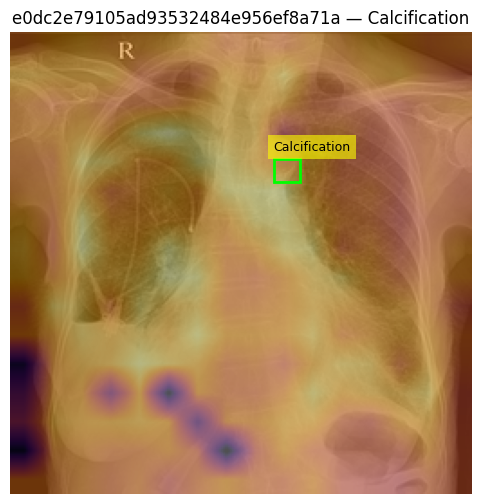

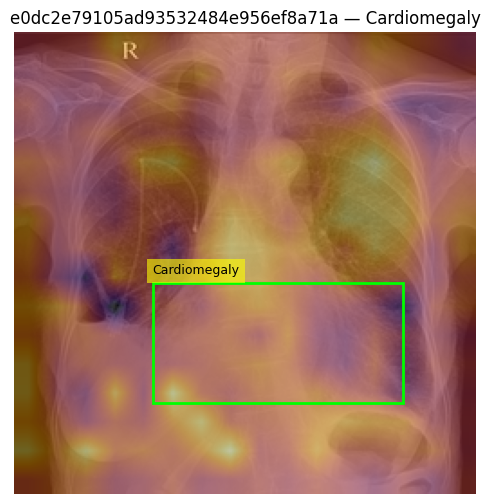

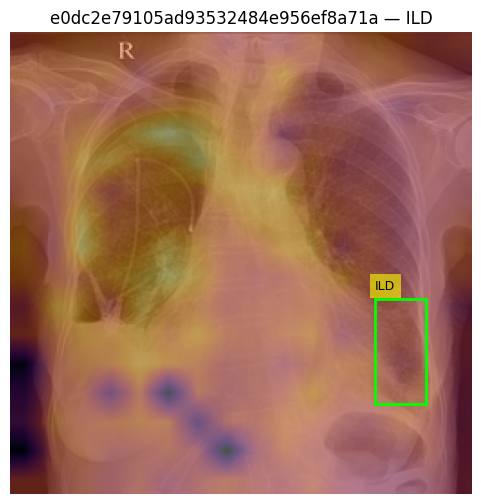

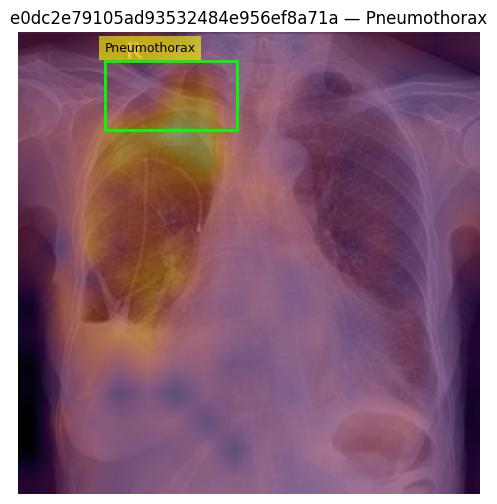

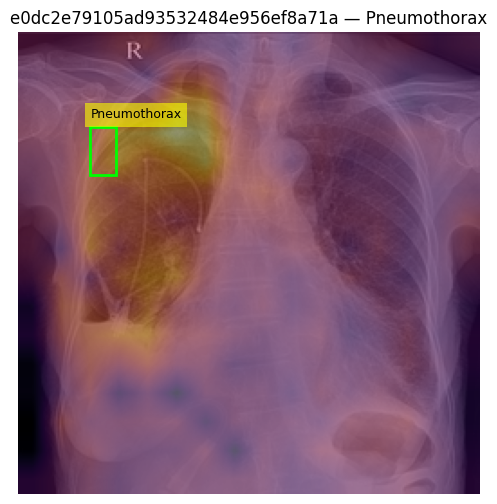

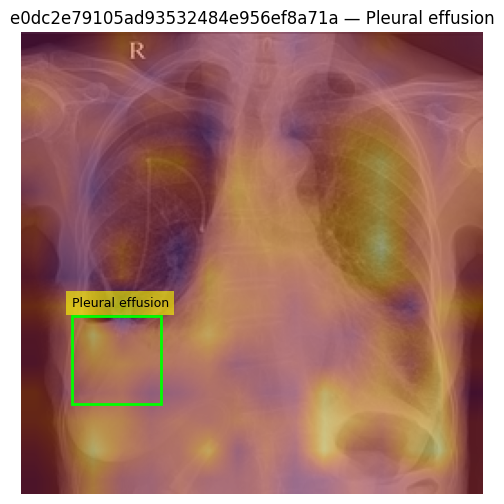

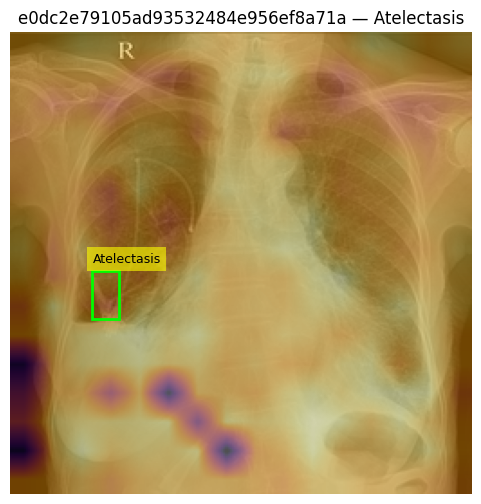

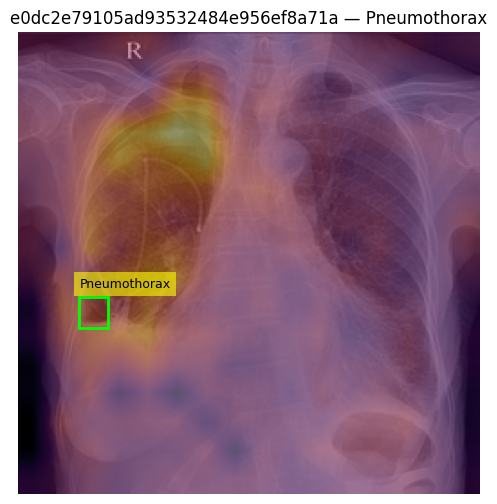

In [41]:
visualize_heatmaps_and_gt_per_label(
    image_id="e0dc2e79105ad93532484e956ef8a71a",
    images_root="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test/",
    annotations_csv="/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/annotations_test.csv",
    meta_csv="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test_meta.csv",
    heatmaps_root="/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad_hooks",
)

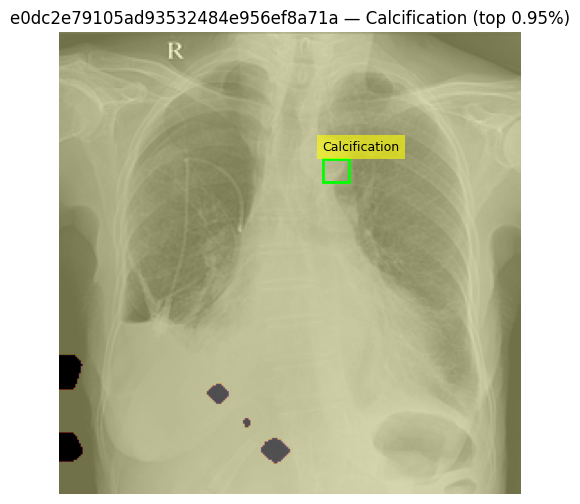

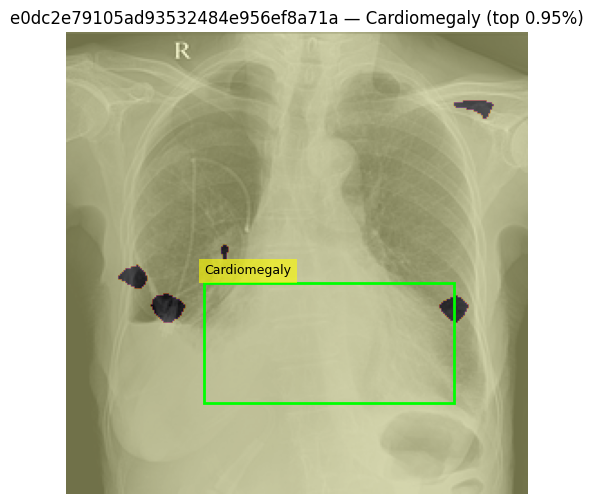

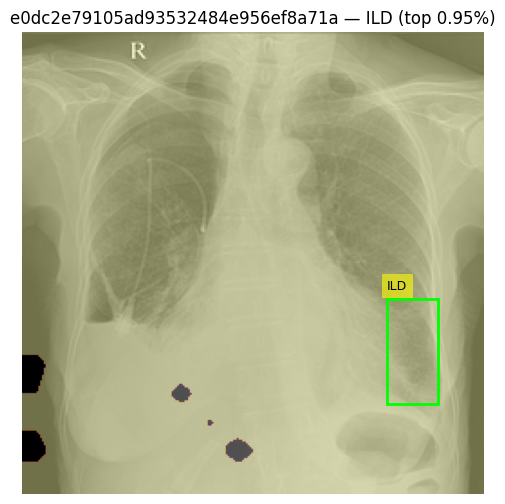

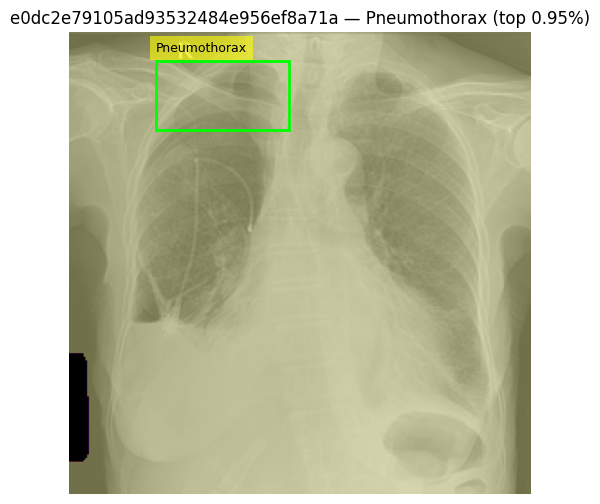

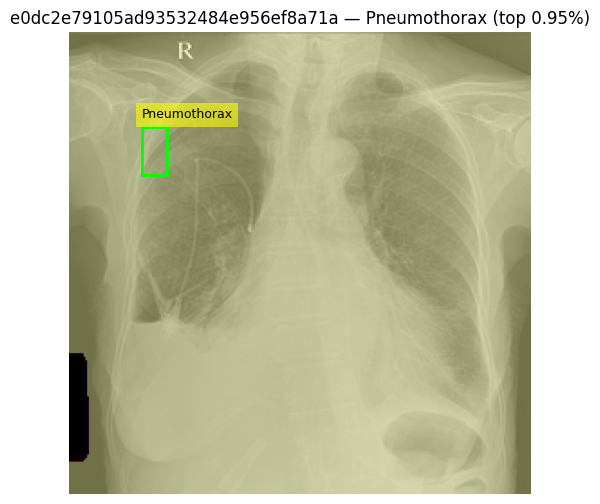

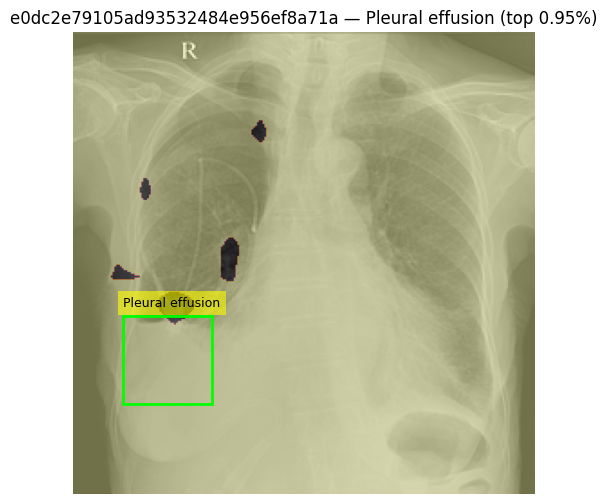

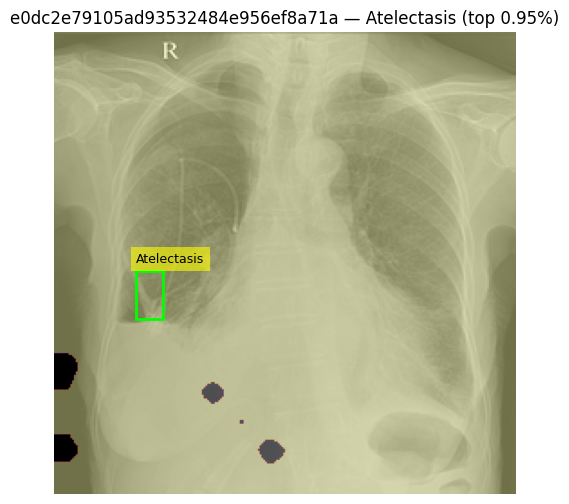

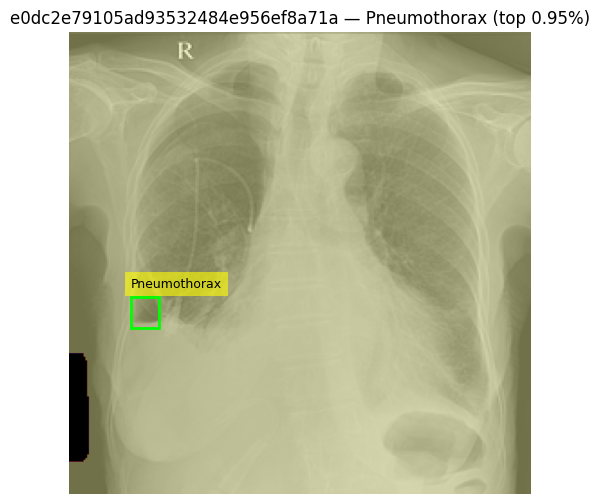

In [42]:
visualize_heatmaps_and_gt_per_label_percentile(
    image_id="e0dc2e79105ad93532484e956ef8a71a",
    images_root="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test/",
    annotations_csv="/home/woody/iwi5/iwi5362h/data/vindr_cxr/annotations/annotations_test.csv",
    meta_csv="/home/woody/iwi5/iwi5362h/data/vindr_cxr/test_meta.csv",
    heatmaps_root="/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad_hooks",
    percentile=0.95
)

In [ ]:
image_id = "e0dc2e79105ad93532484e956ef8a71a"
heatmaps_root = "/home/woody/iwi5/iwi5362h/ALBEF/results/zero_shot_vindr_results/heatmaps_grad_hooks"
images_root = Path(images_root)
heatmaps_root = Path(heatmaps_root)
hm_path = heatmaps_root / f"{image_id}.pt"

In [ ]:
if not hm_path.exists():
    raise FileNotFoundError(f"[Error] Missing heatmap file: {hm_path}")

heatmaps = torch.load(hm_path, map_location="cpu")
heatmaps_np = {}
for label, hm_tensor in heatmaps.items():
    hm = hm_tensor.float()
    # normalize 0–1
    if hm.max() > hm.min():
        hm = (hm - hm.min()) / (hm.max() - hm.min())
    else:
        hm = torch.zeros_like(hm)
    heatmaps_np[label] = hm.detach().cpu().numpy()

In [ ]:
for label, hm_tensor in heatmaps.items(): 
    print(np.nonzero(hm_tensor))